In [1]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [ ]:
root = "./data"

to_tensor = transforms.Compose([
    transforms.ToTensor(),  # converts PIL -> tensor [C,H,W] in [0,1]
])

train_raw = datasets.CIFAR10(root=root, train=True, download=True, transform=to_tensor)
test_raw  = datasets.CIFAR10(root=root, train=False, download=True, transform=to_tensor)

# A simple loader to iterate the training set for statistics
stats_loader = DataLoader(train_raw, batch_size=512, shuffle=False, num_workers=2, pin_memory=True)
len(train_raw), len(test_raw)

100%|██████████| 170M/170M [00:03<00:00, 43.2MB/s]


(50000, 10000)

### **Compute per-channel mean & std (on the training set)**

In [ ]:
# Step 2: Compute mean and std over the training set (per channel)
import math

sum_ = torch.zeros(3)
sum_sq = torch.zeros(3)
num_pixels = 0

for imgs, _ in stats_loader:
    # imgs shape: [B, 3, 32, 32], values in [0,1]
    b, c, h, w = imgs.shape
    imgs = imgs.view(b, c, -1)         # [B, 3, 1024]
    sum_   += imgs.sum(dim=(0, 2))     # per-channel sum
    sum_sq += (imgs ** 2).sum(dim=(0, 2))
    num_pixels += b * h * w

mean = sum_ / num_pixels
std  = (sum_sq / num_pixels - mean ** 2).sqrt()

print("CIFAR-10 train mean :", mean.tolist())
print("CIFAR-10 train std  :", std.tolist())


CIFAR-10 train mean : [0.4913996756076813, 0.48215851187705994, 0.4465310275554657]
CIFAR-10 train std  : [0.24703219532966614, 0.24348489940166473, 0.2615877091884613]


### **Define & Apply Transforms using the computed stats**

In [ ]:
# Step 3: Build your final train/test transforms using the computed mean/std
MEAN = mean.tolist()
STD  = std.tolist()

train_tfms = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD),
])

test_tfms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD),
])

# Create the final datasets/loaders
train_ds = datasets.CIFAR10(root=root, train=True, download=False, transform=train_tfms)
test_ds  = datasets.CIFAR10(root=root, train=False, download=False, transform=test_tfms)

train_loader = DataLoader(train_ds, batch_size=128, shuffle=True, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds, batch_size=128, shuffle=False, num_workers=2, pin_memory=True)

print(f"Train batches: {len(train_loader)} | Test batches: {len(test_loader)}")


Train batches: 391 | Test batches: 79


### **Albumentations Transforms**

(https://github.com/albumentations-team/albumentations)

It defines train_tfms using A.Compose to chain together several augmentation techniques from albumentations.

It defines train_tfms using `A.Compose` to chain together several augmentation techniques from albumentations

1. `A.HorizontalFlip`: Randomly flips images horizontally.
2. `A.ShiftScaleRotate`: Applies random affine transformations (shifting, scaling, and rotating).
3. `A.CoarseDropout`: (this is **CutOut**) Randomly drops rectangular regions from the image and fills them with the calculated mean value.
4. `A.Normalize`: Normalizes the pixel values using the pre-computed `MEAN` and `STD`.
5. `ToTensorV2`: Converts the augmented image (which is a NumPy array at this point in the albumentations pipeline) into a PyTorch tensor and moves the channel dimension to the front (C, H, W).

`AlbuCIFAR` Dataset Class: It creates a custom Dataset class AlbuCIFAR that wraps the standard torchvision.datasets.CIFAR10. T**his is necessary because albumentations works with NumPy arrays in HWC (Height, Width, Channel) format, while torchvision datasets return PIL Images (which are converted to tensors in C, H, W format by their default ToTensor)**. The __getitem__ method converts the PIL Image to a NumPy array before applying the albumentations transform.





In [ ]:
# --- Install (Colab) ---
!pip -q install albumentations==1.4.7

# --- Imports ---
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torchvision import datasets
from torch.utils.data import DataLoader, Dataset
import numpy as np
import cv2
import torch

root = "./data"

# Reuse the stats you computed earlier
MEAN = mean.tolist()   # e.g. [0.4914, 0.4822, 0.4465]
STD  = std.tolist()    # e.g. [0.2470, 0.2435, 0.2616]

# Albumentations' CoarseDropout operates on the raw image (uint8 0..255),
# so convert per-channel mean to 0..255 for fill_value:
fill_value_255 = tuple(int(m * 255) for m in MEAN)   # (R_mean*255, G_mean*255, B_mean*255)

# --- Albumentations transforms ---
train_tfms = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.10, rotate_limit=10,
                       border_mode=cv2.BORDER_REFLECT_101, p=0.7),
    A.CoarseDropout(max_holes=1, max_height=16, max_width=16,
                    min_holes=1, min_height=16, min_width=16,
                    fill_value=fill_value_255, mask_fill_value=None, p=0.5),
    A.Normalize(mean=MEAN, std=STD),
    ToTensorV2(),
])

test_tfms = A.Compose([
    A.Normalize(mean=MEAN, std=STD),
    ToTensorV2(),
])

# --- TorchVision dataset wrapped for Albumentations ---
class AlbuCIFAR(Dataset):
    def __init__(self, root, train=True, transform=None, download=False):
        self.ds = datasets.CIFAR10(root=root, train=train, download=download)
        self.transform = transform

    def __len__(self):
        return len(self.ds)

    def __getitem__(self, idx):
        img, label = self.ds[idx]         # PIL Image (RGB)
        img = np.array(img)               # -> HWC uint8 RGB
        if self.transform is not None:
            img = self.transform(image=img)["image"]  # -> CHW float tensor
        return img, label

# --- Datasets & Loaders ---
train_ds = AlbuCIFAR(root=root, train=True,  transform=train_tfms, download=True)
test_ds  = AlbuCIFAR(root=root, train=False, transform=test_tfms,  download=True)

train_loader = DataLoader(train_ds, batch_size=128, shuffle=True,  num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=128, shuffle=False, num_workers=2, pin_memory=True)

print(f"Train batches: {len(train_loader)} | Test batches: {len(test_loader)}")

# (Optional) quick sanity check
xb, yb = next(iter(train_loader))
print("Train batch:", xb.shape, xb.dtype, xb.min().item(), xb.max().item())  # expect [B,3,32,32], float32

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.7/155.7 kB 8.3 MB/s eta 0:00:00
Train batches: 391 | Test batches: 79
Train batch: torch.Size([128, 3, 32, 32]) torch.float32 -1.989212989807129 2.126791000366211


**Quick sanity check**

In [ ]:
# Peek a batch and verify normalization stats roughly centered
imgs, labels = next(iter(train_loader))
print("Batch shape:", imgs.shape, "| dtype:", imgs.dtype, "| range ~", (imgs.min().item(), imgs.max().item()))
print("Per-channel mean (batch):", imgs.mean(dim=(0,2,3)))
print("Per-channel std  (batch):", imgs.std(dim=(0,2,3)))

Batch shape: torch.Size([128, 3, 32, 32]) | dtype: torch.float32 | range ~ (-1.989212989807129, 2.126791000366211)
Per-channel mean (batch): tensor([ 0.0016, -0.0157, -0.0408])
Per-channel std  (batch): tensor([0.9273, 0.9153, 0.9172])


**Helper: denormalize + show grid**

In [ ]:
# Utils to denormalize and visualize a small grid of images
import math
import torch
import matplotlib.pyplot as plt

# Use MEAN/STD computed earlier (lists) and make tensors for broadcasting
_MEAN = torch.tensor(MEAN).view(1, 3, 1, 1)
_STD  = torch.tensor(STD).view(1, 3, 1, 1)

def denorm(imgs):
    """imgs: tensor [B,C,H,W] normalized with MEAN/STD -> return in [0,1]"""
    x = imgs.clone().cpu()
    x = x * _STD + _MEAN
    return x.clamp(0.0, 1.0)

def show_batch(images, labels, class_names, n=16, cols=8):
    """
    Show n images with titles (class names) in a grid.
    images: [B,C,H,W] tensor (normalized)
    labels: [B] tensor
    """
    n = min(n, images.size(0))
    rows = math.ceil(n / cols)
    imgs = denorm(images[:n])

    plt.figure(figsize=(1.8*cols, 1.8*rows))
    for i in range(n):
        img = imgs[i].permute(1, 2, 0).numpy()  # HWC
        ax = plt.subplot(rows, cols, i+1)
        ax.imshow(img)
        ax.set_title(class_names[int(labels[i])], fontsize=9)
        ax.axis("off")
    plt.tight_layout()
    plt.show()


**View a random training batch (with augmentations)**

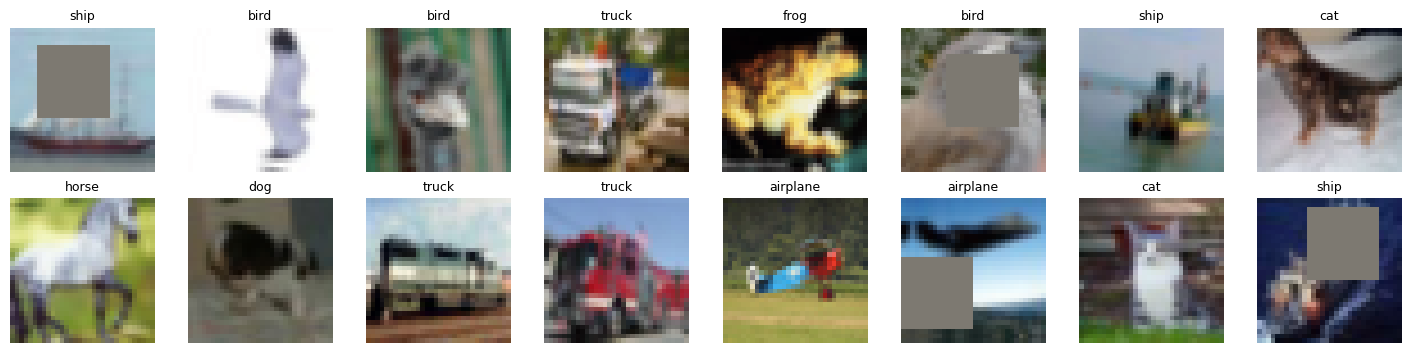

In [ ]:
# CIFAR-10 class names (or use train_ds.classes)
class_names = train_ds.classes if hasattr(train_ds, "classes") else [
    "airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"
]

# Grab a shuffled batch from the training loader and visualize 16 images
train_images, train_labels = next(iter(train_loader))
show_batch(train_images, train_labels, class_names, n=16, cols=8)

**View a random test batch (no augmentations)**

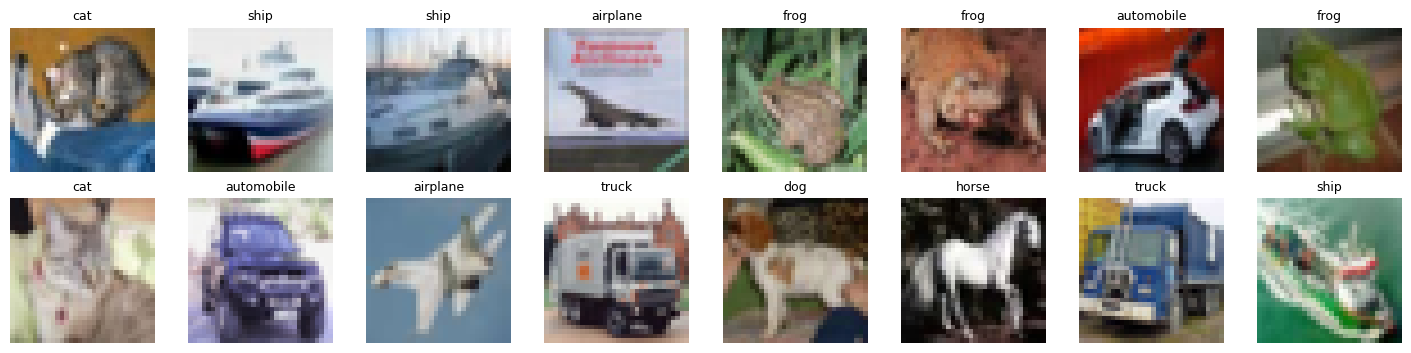

In [ ]:
test_images, test_labels = next(iter(test_loader))
show_batch(test_images, test_labels, class_names, n=16, cols=8)


### **Depthwise Seperable Convolutions**

Imagine a standard 2D convolution operating on an input image with multiple channels (like an RGB image with 3 channels). A standard convolution uses a set of 3D filters (kernel size x kernel size x number of input channels). Each filter convolves across all input channels simultaneously to produce a single output channel. If you want, say, 64 output channels, you need 64 such 3D filters.

This involves a lot of multiplication and addition operations, especially as the number of input and output channels increases. The computational cost is roughly proportional to:


kernel_size * kernel_size * in_channels * out_channels * spatial_output_size

Now, let's look at **Depthwise Separable Convolution**. It splits the standard convolution into two separate steps:

* **Depthwise Convolution**: This step applies a single 2D filter to each input channel independently. If you have an input with in_channels, you'll have in_channels separate 2D filters. Each filter only "sees" one input channel. This results in an output with the same number of channels as the input (in_channels).

The computational cost here is roughly proportional to:

kernel_size * kernel_size * in_channels * spatial_output_size

* **Pointwise Convolution**: This step is a standard 1x1 convolution. It takes the output from the depthwise convolution (which has in_channels) and uses 1x1 filters to combine the information across these channels. If you want out_channels, you'll use out_channels of these 1x1 filters. Each 1x1 filter operates on all in_channels at a single spatial location to produce one value in the output channel.

The computational cost here is roughly proportional to:

1 * 1 * in_channels * out_channels * spatial_output_size

Why is it more efficient?

The total cost of a depthwise separable convolution is the sum of the costs of the depthwise and pointwise steps:

`(kernel_size * kernel_size * in_channels * spatial_output_size) + (1 * 1 * in_channels * out_channels * spatial_output_size)`

If you compare this to the cost of a standard convolution:

`(kernel_size * kernel_size * in_channels * out_channels * spatial_output_size)`

You can see that the standard convolution's cost includes a factor of `kernel_size * kernel_size * out_channels`, while the depthwise separable convolution replaces this with `(kernel_size * kernel_size) + out_channels` (ignoring the spatial size and in_channels for comparison).

Since `out_channels` is typically much larger than `kernel_size * kernel_size`, **the depthwise separable convolution significantly reduces the number of multiplications and additions**. This makes models using depthwise separable convolutions (like MobileNet) much more efficient in terms of computation and the number of parameters, making them suitable for devices with limited resources.

In essence, depthwise separable convolution achieves a similar effect to a standard convolution but by separating the spatial filtering (depthwise) from the channel mixing (pointwise), leading to substantial computational savings.

Assume:

Input channels (in_channels) = 3
Output channels (out_channels) = 64
Kernel size (kernel_size) = 3x3
Spatial output size (let's assume a simplified single output pixel for ease of comparison) = 1
Standard Convolution:

Number of operations ≈ `kernel_size * kernel_size * in_channels * out_channels`

Number of operations ≈ 3 * 3 * 3 * 64 = 9 * 3 * 64 = 27 * 64 = 1728

Depthwise Separable Convolution:

Depthwise Convolution: `Number of operations ≈ kernel_size * kernel_size * in_channels`

Number of operations ≈ 3 * 3 * 3 = 27

Pointwise Convolution: Number of operations ≈ `1 * 1 * in_channels * out_channels`

Number of operations ≈ 1 * 1 * 3 * 64 = 192

Total operations for Depthwise Separable Convolution ≈ Depthwise Operations + Pointwise Operations Total operations ≈ 27 + 192 Total operations ≈ 219

Comparison:

Standard Convolution Operations: 1728 while Depthwise Separable Convolution Operations: 219

In this example, the depthwise separable convolution requires significantly fewer operations (219 vs 1728), illustrating its computational efficiency. This difference becomes even more pronounced with larger kernel sizes and a higher number of channels.

### **Receptive Field**

In the context of Convolutional Neural Networks (CNNs), the receptive field of a neuron in a particular layer *is the region in the original input image that influences that neuron's activation*.

Think of it like this:

* First Layer: A neuron in the first convolutional layer processes a small patch of the input image (defined by the kernel size). So, its receptive field is just that small patch.

* Second Layer: A neuron in the second convolutional layer processes a patch of the output from the first layer. Since each point in the first layer's output corresponds to a small region in the input, a neuron in the second layer is indirectly influenced by a larger region in the original input image. Its receptive field is the combination of all the regions in the input that contributed to the patch it's currently processing from the first layer's output.

* Deeper Layers: As you go deeper into the network, each layer's input is the output of the previous layer. The receptive field of a neuron in a deeper layer grows because it's influenced by a larger and larger area of the original input image.
Key Concepts:

**Kernel Size**: A larger kernel size in a layer increases the receptive field of the neurons in that layer.

**Stride**: A larger stride in a layer causes the receptive field to grow faster in subsequent layers.

**Padding**: Padding affects the effective size of the input and can influence how the receptive field is calculated, but the core idea of the region of influence remains.

**Pooling Layers**: Pooling layers (like max pooling) also increase the receptive field because a single output value in a pooling layer summarizes information from a larger spatial region in the preceding layer's output.

**Dilation**: Dilated convolutions (as seen in your notebook) are particularly effective at increasing the receptive field without increasing the number of parameters or reducing the spatial dimensions of the feature maps as drastically as pooling or larger strides.
Why is the Receptive Field Important?

*Understanding what the network "sees": The receptive field tells you how much spatial context a neuron is considering when making a decision or extracting a feature.*

**Designing Network Architecture**: Understanding how the receptive field grows through the layers helps in designing networks that can capture features at different scales. For tasks like object detection or semantic segmentation, it's important for the network to have a receptive field large enough to cover the objects or regions of interest in the image.

**Troubleshooting**: If your network isn't performing well, analyzing the receptive field can sometimes help diagnose issues, for example, if the receptive field is too small to capture the necessary context.

### **Dilated Convolutions (also known as Atrous Convolutions)**

Standard convolutions operate on a contiguous block of pixels defined by the kernel size. A 3x3 kernel looks at a 3x3 area directly around the central pixel.

**Dilated convolutions** introduce a "**dilation rate**" that creates gaps between the kernel elements. *Imagine taking a standard kernel and "stretching" it by inserting zeros between the weights*. This allows the kernel to cover a larger area in the input feature map without increasing the number of parameters or the computational cost of the convolution itself.

**How Dilated Convolutions Increase the Receptive Field**

The effective receptive field of a dilated convolution is larger than a standard convolution with the same kernel size. The formula for the effective kernel size of a dilated convolution is:

`Effective_kernel_size = kernel_size + (kernel_size - 1) * (dilation_rate - 1)`

For a 3x3 kernel:

* Dilation Rate 1: 3 + (3 - 1) * (1 - 1) = 3 + 2 * 0 = 3. Effective size is 3x3.
* Dilation Rate 2: 3 + (3 - 1) * (2 - 1) = 3 + 2 * 1 = 5. Effective size is 5x5.
* Dilation Rate 3: 3 + (3 - 1) * (3 - 1) = 3 + 2 * 2 = 7. Effective size is 7x7.

This means a neuron in a layer with a dilated convolution is influenced by a larger area of the previous layer's output feature map compared to a standard convolution with the same kernel size. Since the receptive field is cumulative across layers, ***this effectively expands the receptive field in the original input image much faster without losing spatial resolution (as pooling does) or significantly increasing computation (as larger kernel sizes do)***.


**By how much does one such convolution increase the receptive field?**

The increase in receptive field size from a single layer depends on its kernel size, dilation rate, and stride, as well as the receptive field size of the previous layer.

A simpler way to think about the increase in receptive field size added by a single layer is related to the effective kernel size and stride.

If a layer has a receptive field size of RF_in from the previous layer, a kernel size k, dilation d, and stride s, the new receptive field size RF_out can be calculated iteratively:

`RF_out = RF_in + (Effective_kernel_size - 1) * stride_cumulative`

Where `Effective_kernel_size = k + (k - 1) * (d - 1)` and *stride_cumulative is the product of strides of all layers up to the current one*.

However, a more intuitive way to look at the contribution of a single layer to the receptive field expansion is by considering the difference between its effective kernel size and 1, multiplied by the cumulative stride up to the previous layer.

For a layer with kernel k, dilation d, and stride s, the increase in receptive field size relative to a layer with a 1x1 kernel and no dilation (which would have an effective kernel size of 1) is roughly:

`(Effective_kernel_size - 1) * cumulative_stride_before_this_layer`

Using the effective kernel size formula:

`Increase ≈ (k + (k - 1) * (d - 1) - 1) * cumulative_stride_before_this_layer`

For example, in your NetCIFAR10 model, the DWSeparableConv with dilation=2 in self.c2 (which has k=3, d=2, s=1 and follows layers with cumulative stride 1) contributes an increase of roughly:

`(3 + (3 - 1) * (2 - 1) - 1) * 1 = (3 + 2 * 1 - 1) * 1 = (5 - 1) * 1 = 4`

This layer adds 4 to the receptive field size built up by the preceding layers. The layer with dilation=3 in self.c4 (which has k=3, d=3, s=1 and follows layers with cumulative stride 2 due to the stride=2 layer before it) contributes:

`3 + (3 - 1) * (3 - 1) - 1) * 2 = (3 + 2 * 2 - 1) * 2 = (7 - 1) * 2 = 6 * 2 = 12`

This layer adds 12 to the receptive field size built up before it.

**Dilated convolutions are powerful because they allow the network to have a wider view of the input without downsampling, which is crucial for tasks where maintaining spatial resolution is important (like semantic segmentation).**

**Load Model**

In [2]:
from tiny_cifar10_net import NetCIFAR10_Tiny

model = NetCIFAR10_Tiny()
model

NetCIFAR10_Tiny(
  (c1): Sequential(
    (0): ConvBNReLU(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): ConvBNReLU(
      (0): Conv2d(16, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
  )
  (c2): Sequential(
    (0): DWSeparableConv(
      (dw): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=24, bias=False)
      (bn_dw): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (pw): Conv2d(24, 36, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn_pw): BatchNorm2d(36, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): DWSeparableConv(
      (dw): Conv2d(36, 36, kernel_size=(3, 

Let's calculate the receptive field (RF) step by step for the `NetCIFAR10_Tiny` model.

The formula for the effective kernel size (`Effective_kernel_size`) of a dilated convolution is:
`Effective_kernel_size = kernel_size + (kernel_size - 1) * (dilation_rate - 1)`

The iterative formula for the receptive field size (`RF_out`) after a layer is:
`RF_out = RF_in + (Effective_kernel_size - 1) * stride_cumulative`
where `RF_in` is the receptive field of the previous layer and `stride_cumulative` is the product of strides of all layers up to the *previous* layer.

Assuming the input image has an RF of 1 (a single pixel):

**C1: (B,3,32,32) -> (B,32,32,32)**
- **Layer 1 (ConvBNReLU):** `k=3`, `stride=1`, `dilation=1`
  - `Effective_kernel_size = 3 + (3 - 1) * (1 - 1) = 3`
  - `RF = RF_in + (Effective_kernel_size - 1) * stride_cumulative = 1 + (3 - 1) * 1 = 1 + 2 = 3`
  - `Cumulative Stride = 1`
- **Layer 2 (ConvBNReLU):** `k=3`, `stride=1`, `dilation=1`
  - `Effective_kernel_size = 3 + (3 - 1) * (1 - 1) = 3`
  - `RF = RF_in + (Effective_kernel_size - 1) * stride_cumulative = 3 + (3 - 1) * 1 = 3 + 2 = 5`
  - `Cumulative Stride = 1 * 1 = 1`

**C2: (B,24,32,32) -> (B,36,32,32)**
- **Layer 3 (DWSeparableConv - Depthwise):** `k=3`, `stride=1`, `dilation=1`
  - `Effective_kernel_size = 3`
  - `RF = RF_in + (Effective_kernel_size - 1) * stride_cumulative = 5 + (3 - 1) * 1 = 5 + 2 = 7`
  - `Cumulative Stride = 1 * 1 = 1`
- **Layer 4 (DWSeparableConv - Pointwise):** `k=1`, `stride=1`, `dilation=1`
  - `Effective_kernel_size = 1`
  - `RF = RF_in + (Effective_kernel_size - 1) * stride_cumulative = 7 + (1 - 1) * 1 = 7 + 0 = 7`
  - `Cumulative Stride = 1 * 1 = 1`
- **Layer 5 (DWSeparableConv - Depthwise):** `k=3`, `stride=1`, `dilation=2`
  - `Effective_kernel_size = 3 + (3 - 1) * (2 - 1) = 5`
  - `RF = RF_in + (Effective_kernel_size - 1) * stride_cumulative = 7 + (5 - 1) * 1 = 7 + 4 = 11`
  - `Cumulative Stride = 1 * 1 = 1`
- **Layer 6 (DWSeparableConv - Pointwise):** `k=1`, `stride=1`, `dilation=1`
  - `Effective_kernel_size = 1`
  - `RF = RF_in + (Effective_kernel_size - 1) * stride_cumulative = 11 + (1 - 1) * 1 = 11 + 0 = 11`
  - `Cumulative Stride = 1 * 1 = 1`

**C3: (B,36,32,32) -> (B,48,32,32)**
- **Layer 7 (DWSeparableConv - Depthwise):** `k=3`, `stride=1`, `dilation=1`
  - `Effective_kernel_size = 3`
  - `RF = RF_in + (Effective_kernel_size - 1) * stride_cumulative = 11 + (3 - 1) * 1 = 11 + 2 = 13`
  - `Cumulative Stride = 1 * 1 = 1`
- **Layer 8 (DWSeparableConv - Pointwise):** `k=1`, `stride=1`, `dilation=1`
  - `Effective_kernel_size = 1`
  - `RF = RF_in + (Effective_kernel_size - 1) * stride_cumulative = 13 + (1 - 1) * 1 = 13 + 0 = 13`
  - `Cumulative Stride = 1 * 1 = 1`
- **Layer 9 (DWSeparableConv - Depthwise):** `k=3`, `stride=1`, `dilation=1`
  - `Effective_kernel_size = 3`
  - `RF = RF_in + (Effective_kernel_size - 1) * stride_cumulative = 13 + (3 - 1) * 1 = 13 + 2 = 15`
  - `Cumulative Stride = 1 * 1 = 1`
- **Layer 10 (DWSeparableConv - Pointwise):** `k=1`, `stride=1`, `dilation=1`
  - `Effective_kernel_size = 1`
  - `RF = RF_in + (Effective_kernel_size - 1) * stride_cumulative = 15 + (1 - 1) * 1 = 15 + 0 = 15`
  - `Cumulative Stride = 1 * 1 = 1`

**C4: downsample only here (no maxpool)**
- **Layer 11 (DWSeparableConv - Depthwise):** `k=3`, `stride=2`, `dilation=1`
  - `Effective_kernel_size = 3`
  - `RF = RF_in + (Effective_kernel_size - 1) * stride_cumulative = 15 + (3 - 1) * 1 = 15 + 2 = 17`
  - `Cumulative Stride = 1 * 2 = 2`
- **Layer 12 (DWSeparableConv - Pointwise):** `k=1`, `stride=1`, `dilation=1`
  - `Effective_kernel_size = 1`
  - `RF = RF_in + (Effective_kernel_size - 1) * stride_cumulative = 17 + (1 - 1) * 2 = 17 + 0 = 17`
  - `Cumulative Stride = 2 * 1 = 2`
- **Layer 13 (DWSeparableConv - Depthwise):** `k=3`, `stride=1`, `dilation=2`
  - `Effective_kernel_size = 3 + (3 - 1) * (2 - 1) = 5`
  - `RF = RF_in + (Effective_kernel_size - 1) * stride_cumulative = 17 + (5 - 1) * 2 = 17 + 4 * 2 = 17 + 8 = 25`
  - `Cumulative Stride = 2 * 1 = 2`
- **Layer 14 (DWSeparableConv - Pointwise):** `k=1`, `stride=1`, `dilation=1`
  - `Effective_kernel_size = 1`
  - `RF = RF_in + (Effective_kernel_size - 1) * stride_cumulative = 25 + (1 - 1) * 2 = 25 + 0 = 25`
  - `Cumulative Stride = 2 * 1 = 2`
- **Layer 15 (DWSeparableConv - Depthwise):** `k=3`, `stride=1`, `dilation=3`
  - `Effective_kernel_size = 3 + (3 - 1) * (3 - 1) = 7`
  - `RF = RF_in + (Effective_kernel_size - 1) * stride_cumulative = 25 + (7 - 1) * 2 = 25 + 6 * 2 = 25 + 12 = 37`
  - `Cumulative Stride = 2 * 1 = 2`
- **Layer 16 (DWSeparableConv - Pointwise):** `k=1`, `stride=1`, `dilation=1`
  - `Effective_kernel_size = 1`
  - `RF = RF_in + (Effective_kernel_size - 1) * stride_cumulative = 37 + (1 - 1) * 2 = 37 + 0 = 37`
  - `Cumulative Stride = 2 * 1 = 2`
- **Layer 17 (DWSeparableConv - Depthwise):** `k=3`, `stride=1`, `dilation=1`
  - `Effective_kernel_size = 3`
  - `RF = RF_in + (Effective_kernel_size - 1) * stride_cumulative = 37 + (3 - 1) * 2 = 37 + 2 * 2 = 37 + 4 = 41`
  - `Cumulative Stride = 2 * 1 = 2`
- **Layer 18 (DWSeparableConv - Pointwise):** `k=1`, `stride=1`, `dilation=1`
  - `Effective_kernel_size = 1`
  - `RF = RF_in + (Effective_kernel_size - 1) * stride_cumulative = 41 + (1 - 1) * 2 = 41 + 0 = 41`
  - `Cumulative Stride = 2 * 1 = 2`
- **Layer 19 (DWSeparableConv - Depthwise):** `k=3`, `stride=1`, `dilation=1`
  - `Effective_kernel_size = 3`
  - `RF = RF_in + (Effective_kernel_size - 1) * stride_cumulative = 41 + (3 - 1) * 2 = 41 + 2 * 2 = 41 + 4 = 45`
  - `Cumulative Stride = 2 * 1 = 2`
- **Layer 20 (DWSeparableConv - Pointwise):** `k=1`, `stride=1`, `dilation=1`
  - `Effective_kernel_size = 1`
  - `RF = RF_in + (Effective_kernel_size - 1) * stride_cumulative = 45 + (1 - 1) * 2 = 45 + 0 = 45`
  - `Cumulative Stride = 2 * 1 = 2`

**GAP**
- The Global Average Pooling layer effectively has a receptive field equal to the entire input size of the layer before it. The input to GAP is 16x16 with a cumulative stride of 2 from the original input. The RF before GAP is 45.

**Head**
- The 1x1 convolution head processes the output of the GAP layer, which is a single spatial location summarizing the entire receptive field of the last convolutional layer.

**Therefore, the receptive field before the Global Average Pooling layer is 45.**

In [3]:
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

model = model.to(device)
summary(model, input_size=(3, 32, 32))

cpu
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             432
       BatchNorm2d-2           [-1, 16, 32, 32]              32
              ReLU-3           [-1, 16, 32, 32]               0
            Conv2d-4           [-1, 24, 32, 32]           3,456
       BatchNorm2d-5           [-1, 24, 32, 32]              48
              ReLU-6           [-1, 24, 32, 32]               0
            Conv2d-7           [-1, 24, 32, 32]             216
       BatchNorm2d-8           [-1, 24, 32, 32]              48
            Conv2d-9           [-1, 36, 32, 32]             864
      BatchNorm2d-10           [-1, 36, 32, 32]              72
  DWSeparableConv-11           [-1, 36, 32, 32]               0
           Conv2d-12           [-1, 36, 32, 32]             324
      BatchNorm2d-13           [-1, 36, 32, 32]              72
           Conv2d-14           [-1,

In [ ]:
import copy
import torch
import torch.nn.functional as F
from tqdm import tqdm

# keep your history lists (now store epoch-level stats)
train_losses, test_losses = [], []
train_acc,    test_acc    = [], []

class EarlyStopping:
    def __init__(self, patience=6, min_delta=1e-4, restore_best_weights=True, checkpoint_path=None):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.checkpoint_path = checkpoint_path
        self.best = float('inf')
        self.wait = 0
        self.best_state = None

    def step(self, val_loss, model):
        improved = (self.best - val_loss) > self.min_delta
        if improved:
            self.best = val_loss
            self.wait = 0
            if self.restore_best_weights:
                self.best_state = copy.deepcopy(model.state_dict())
            if self.checkpoint_path:
                torch.save(model.state_dict(), self.checkpoint_path)
        else:
            self.wait += 1
        return self.wait >= self.patience

    def load_best(self, model):
        if self.restore_best_weights and self.best_state is not None:
            model.load_state_dict(self.best_state)
        elif self.checkpoint_path:
            model.load_state_dict(torch.load(self.checkpoint_path, map_location="cpu"))

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    pbar = tqdm(train_loader, desc=f"Train E{epoch:02d}")
    correct, total = 0, 0
    running_loss = 0.0

    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        y_pred = model(data)
        loss = F.nll_loss(y_pred, target)
        loss.backward()
        optimizer.step()

        # stats
        running_loss += loss.item() * data.size(0)
        pred = y_pred.argmax(dim=1)
        correct += (pred == target).sum().item()
        total += data.size(0)

        pbar.set_postfix(loss=f"{loss.item():.4f}", acc=f"{100*correct/total:.2f}%")

    epoch_loss = running_loss / total
    epoch_acc  = 100.0 * correct / total
    train_losses.append(epoch_loss)
    train_acc.append(epoch_acc)
    return epoch_loss, epoch_acc

def test(model, device, test_loader, epoch=None):
    model.eval()
    test_loss_sum, correct, total = 0.0, 0, 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = F.nll_loss(output, target, reduction='sum')  # sum over batch
            test_loss_sum += loss.item()
            pred = output.argmax(dim=1)
            correct += (pred == target).sum().item()
            total += data.size(0)

    avg_loss = test_loss_sum / total
    acc = 100.0 * correct / total
    test_losses.append(avg_loss)
    test_acc.append(acc)

    if epoch is not None:
        print(f"\nVal E{epoch:02d}: loss={avg_loss:.4f}, acc={correct}/{total} ({acc:.2f}%)\n")
    else:
        print(f"\nVal: loss={avg_loss:.4f}, acc={correct}/{total} ({acc:.2f}%)\n")

    return avg_loss, acc


In [ ]:
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print("Device:", device)

model = NetCIFAR10_Tiny().to(device)

optimizer = optim.SGD(model.parameters(), lr=0.045, momentum=0.9, weight_decay=5e-4, nesterov=True)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2)

early_stop = EarlyStopping(
    patience=6,               # let LR reduce a few times before stopping
    min_delta=1e-4,
    restore_best_weights=True,
    checkpoint_path="best_cifar10_tiny.pt"  # optional
)

EPOCHS = 50
for epoch in range(1, EPOCHS + 1):
    tr_loss, tr_acc = train(model, device, train_loader, optimizer, epoch)
    val_loss, val_acc = test(model, device, test_loader, epoch)

    # step LR on validation loss (ReduceLROnPlateau expects a scalar)
    scheduler.step(val_loss)

    # early stopping on validation loss
    if early_stop.step(val_loss, model):
        print(f"Early stopping at epoch {epoch}. Best val loss: {early_stop.best:.4f}")
        break

# restore best weights (from memory or checkpoint)
early_stop.load_best(model)
print("Loaded best model (early stopping). Best val loss:", f"{early_stop.best:.4f}")


Device: cuda


Train E01: 100%|██████████| 391/391 [00:51<00:00,  7.53it/s, acc=35.03%, loss=1.5676]



Val E01: loss=1.4315, acc=4674/10000 (46.74%)



Train E02: 100%|██████████| 391/391 [00:52<00:00,  7.51it/s, acc=51.66%, loss=1.0541]



Val E02: loss=1.1386, acc=5930/10000 (59.30%)



Train E03: 100%|██████████| 391/391 [00:51<00:00,  7.54it/s, acc=59.35%, loss=1.1905]



Val E03: loss=0.9987, acc=6482/10000 (64.82%)



Train E04: 100%|██████████| 391/391 [00:52<00:00,  7.43it/s, acc=63.93%, loss=1.0568]



Val E04: loss=0.9431, acc=6677/10000 (66.77%)



Train E05: 100%|██████████| 391/391 [00:51<00:00,  7.58it/s, acc=66.84%, loss=0.8626]



Val E05: loss=0.8186, acc=7105/10000 (71.05%)



Train E06: 100%|██████████| 391/391 [00:51<00:00,  7.56it/s, acc=68.74%, loss=0.7843]



Val E06: loss=0.8144, acc=7170/10000 (71.70%)



Train E07: 100%|██████████| 391/391 [00:52<00:00,  7.51it/s, acc=69.66%, loss=0.8298]



Val E07: loss=0.7837, acc=7308/10000 (73.08%)



Train E08: 100%|██████████| 391/391 [00:51<00:00,  7.60it/s, acc=70.72%, loss=0.7705]



Val E08: loss=0.7666, acc=7409/10000 (74.09%)



Train E09: 100%|██████████| 391/391 [00:53<00:00,  7.25it/s, acc=71.90%, loss=0.9335]



Val E09: loss=0.7935, acc=7300/10000 (73.00%)



Train E10: 100%|██████████| 391/391 [00:53<00:00,  7.38it/s, acc=72.21%, loss=1.0078]



Val E10: loss=0.7317, acc=7501/10000 (75.01%)



Train E11: 100%|██████████| 391/391 [00:52<00:00,  7.40it/s, acc=72.61%, loss=0.7129]



Val E11: loss=0.7140, acc=7472/10000 (74.72%)



Train E12: 100%|██████████| 391/391 [00:52<00:00,  7.43it/s, acc=73.12%, loss=0.7297]



Val E12: loss=0.7216, acc=7530/10000 (75.30%)



Train E13: 100%|██████████| 391/391 [00:53<00:00,  7.37it/s, acc=73.39%, loss=0.6775]



Val E13: loss=0.6634, acc=7711/10000 (77.11%)



Train E14: 100%|██████████| 391/391 [00:54<00:00,  7.21it/s, acc=74.02%, loss=0.8518]



Val E14: loss=0.6490, acc=7779/10000 (77.79%)



Train E15: 100%|██████████| 391/391 [00:52<00:00,  7.40it/s, acc=74.36%, loss=0.7840]



Val E15: loss=0.6595, acc=7712/10000 (77.12%)



Train E16: 100%|██████████| 391/391 [00:52<00:00,  7.51it/s, acc=74.69%, loss=0.7349]



Val E16: loss=0.6183, acc=7887/10000 (78.87%)



Train E17: 100%|██████████| 391/391 [00:52<00:00,  7.42it/s, acc=74.90%, loss=0.9129]



Val E17: loss=0.7629, acc=7317/10000 (73.17%)



Train E18: 100%|██████████| 391/391 [00:53<00:00,  7.32it/s, acc=75.19%, loss=0.8183]



Val E18: loss=0.6602, acc=7722/10000 (77.22%)



Train E19: 100%|██████████| 391/391 [00:53<00:00,  7.28it/s, acc=75.26%, loss=0.5072]



Val E19: loss=0.6981, acc=7642/10000 (76.42%)



Train E20: 100%|██████████| 391/391 [00:52<00:00,  7.41it/s, acc=79.24%, loss=0.4252]



Val E20: loss=0.4695, acc=8372/10000 (83.72%)



Train E21: 100%|██████████| 391/391 [00:53<00:00,  7.37it/s, acc=80.29%, loss=0.6366]



Val E21: loss=0.4433, acc=8476/10000 (84.76%)



Train E22: 100%|██████████| 391/391 [00:52<00:00,  7.47it/s, acc=80.91%, loss=0.5783]



Val E22: loss=0.4311, acc=8510/10000 (85.10%)



Train E23: 100%|██████████| 391/391 [00:54<00:00,  7.22it/s, acc=81.12%, loss=0.5552]



Val E23: loss=0.4277, acc=8504/10000 (85.04%)



Train E24: 100%|██████████| 391/391 [00:52<00:00,  7.43it/s, acc=81.21%, loss=0.5787]



Val E24: loss=0.4200, acc=8533/10000 (85.33%)



Train E25: 100%|██████████| 391/391 [00:52<00:00,  7.52it/s, acc=81.58%, loss=0.4129]



Val E25: loss=0.4202, acc=8548/10000 (85.48%)



Train E26: 100%|██████████| 391/391 [00:52<00:00,  7.43it/s, acc=81.69%, loss=0.5793]



Val E26: loss=0.4164, acc=8572/10000 (85.72%)



Train E27: 100%|██████████| 391/391 [00:52<00:00,  7.38it/s, acc=81.74%, loss=0.9158]



Val E27: loss=0.4112, acc=8586/10000 (85.86%)



Train E28: 100%|██████████| 391/391 [00:53<00:00,  7.29it/s, acc=81.97%, loss=0.6713]



Val E28: loss=0.4086, acc=8602/10000 (86.02%)



Train E29: 100%|██████████| 391/391 [00:52<00:00,  7.46it/s, acc=81.92%, loss=0.5758]



Val E29: loss=0.4135, acc=8571/10000 (85.71%)



Train E30: 100%|██████████| 391/391 [00:52<00:00,  7.48it/s, acc=82.07%, loss=0.6714]



Val E30: loss=0.4098, acc=8567/10000 (85.67%)



Train E31: 100%|██████████| 391/391 [00:51<00:00,  7.54it/s, acc=82.09%, loss=0.6191]



Val E31: loss=0.4078, acc=8605/10000 (86.05%)



Train E32: 100%|██████████| 391/391 [00:52<00:00,  7.47it/s, acc=82.30%, loss=0.7184]



Val E32: loss=0.4010, acc=8612/10000 (86.12%)



Train E33: 100%|██████████| 391/391 [00:52<00:00,  7.38it/s, acc=82.22%, loss=0.4766]



Val E33: loss=0.4008, acc=8610/10000 (86.10%)



Train E34: 100%|██████████| 391/391 [00:51<00:00,  7.56it/s, acc=82.35%, loss=0.5130]



Val E34: loss=0.3999, acc=8594/10000 (85.94%)



Train E35: 100%|██████████| 391/391 [00:51<00:00,  7.57it/s, acc=82.29%, loss=0.3701]



Val E35: loss=0.3949, acc=8627/10000 (86.27%)



Train E36: 100%|██████████| 391/391 [00:51<00:00,  7.53it/s, acc=82.42%, loss=0.6497]



Val E36: loss=0.3992, acc=8623/10000 (86.23%)



Train E37: 100%|██████████| 391/391 [00:52<00:00,  7.38it/s, acc=82.55%, loss=0.5194]



Val E37: loss=0.4021, acc=8577/10000 (85.77%)



Train E38: 100%|██████████| 391/391 [00:53<00:00,  7.34it/s, acc=82.76%, loss=0.5037]



Val E38: loss=0.4214, acc=8553/10000 (85.53%)



Train E39: 100%|██████████| 391/391 [00:52<00:00,  7.49it/s, acc=83.22%, loss=0.5413]



Val E39: loss=0.3797, acc=8692/10000 (86.92%)



Train E40: 100%|██████████| 391/391 [00:52<00:00,  7.52it/s, acc=83.53%, loss=0.7379]



Val E40: loss=0.3756, acc=8699/10000 (86.99%)



Train E41: 100%|██████████| 391/391 [00:52<00:00,  7.42it/s, acc=83.40%, loss=0.4570]



Val E41: loss=0.3757, acc=8686/10000 (86.86%)



Train E42: 100%|██████████| 391/391 [00:51<00:00,  7.56it/s, acc=83.58%, loss=0.5838]



Val E42: loss=0.3730, acc=8703/10000 (87.03%)



Train E43: 100%|██████████| 391/391 [00:53<00:00,  7.36it/s, acc=83.70%, loss=0.5344]



Val E43: loss=0.3741, acc=8709/10000 (87.09%)



Train E44: 100%|██████████| 391/391 [00:52<00:00,  7.38it/s, acc=83.78%, loss=0.4697]



Val E44: loss=0.3736, acc=8701/10000 (87.01%)



Train E45: 100%|██████████| 391/391 [00:51<00:00,  7.52it/s, acc=83.96%, loss=0.5499]



Val E45: loss=0.3729, acc=8722/10000 (87.22%)



Train E46: 100%|██████████| 391/391 [00:53<00:00,  7.36it/s, acc=83.84%, loss=0.4734]



Val E46: loss=0.3734, acc=8712/10000 (87.12%)



Train E47: 100%|██████████| 391/391 [00:54<00:00,  7.20it/s, acc=83.89%, loss=0.4975]



Val E47: loss=0.3753, acc=8728/10000 (87.28%)



Train E48: 100%|██████████| 391/391 [00:53<00:00,  7.35it/s, acc=83.99%, loss=0.4839]



Val E48: loss=0.3723, acc=8725/10000 (87.25%)



Train E49: 100%|██████████| 391/391 [00:51<00:00,  7.54it/s, acc=83.72%, loss=0.5220]



Val E49: loss=0.3718, acc=8713/10000 (87.13%)



Train E50: 100%|██████████| 391/391 [00:52<00:00,  7.50it/s, acc=83.98%, loss=0.5869]



Val E50: loss=0.3716, acc=8731/10000 (87.31%)

Loaded best model (early stopping). Best val loss: 0.3716
